In [2]:
from IPython.display import HTML
HTML('''
    <style> body {font-family: "Roboto Condensed Light", "Roboto Condensed";} h2 {padding: 10px 12px; background-color: #E64626; position: static; color: #ffffff; font-size: 40px;} .text_cell_render p { font-size: 15px; } .text_cell_render h1 { font-size: 30px; } h1 {padding: 10px 12px; background-color: #E64626; color: #ffffff; font-size: 40px;} .text_cell_render h3 { padding: 10px 12px; background-color: #0148A4; position: static; color: #ffffff; font-size: 20px;} h4:before{ 
    content: "@"; font-family:"Wingdings"; font-style:regular; margin-right: 4px;} .text_cell_render h4 {padding: 8px; font-family: "Roboto Condensed Light"; position: static; font-style: italic; background-color: #FFB800; color: #ffffff; font-size: 18px; text-align: center; border-radius: 5px;}input[type=submit] {background-color: #E64626; border: solid; border-color: #734036; color: white; padding: 8px 16px; text-decoration: none; margin: 4px 2px; cursor: pointer; border-radius: 20px;}</style>
''')

In [3]:
from sqlalchemy import create_engine, text
from sqlalchemy.orm import Session
import numpy as np
import psycopg2
import psycopg2.extras
import json
import os
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'iframe'

credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        port       = db_conn_dict['port']
        try:
            db = create_engine(f'postgresql+psycopg2://{db_user}:{db_pw}@{host}:{port}/{default_db}', echo=False)#, plugins=["geoalchemy2"])
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

#edited to not need conn input
def query(sqlcmd, args=None, df=True):
    global conn
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(text(sqlcmd), args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

#can call this instead of having to redo everything when connection breaks
def reset():
    global db, conn
    db, conn = pgconnect(credentials)
    conn.execute(text("CREATE EXTENSION IF NOT EXISTS postgis;"))
    #conn.commit()
    conn.execute(text("CREATE SCHEMA IF NOT EXISTS sa2; SET search_path TO sa2, public;"))
    #conn.commit()

reset()

Connected successfully.


In [4]:
#Geopandas imports
#%matplotlib inline

from __future__ import (absolute_import, division, print_function)
import os

import matplotlib as mpl
import matplotlib.pyplot as plt

from geoalchemy2 import Geometry, WKTElement

from shapely.geometry import Point, Polygon, MultiPolygon
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
mpl.__version__, pd.__version__, gpd.__version__

('3.10.3', '2.2.3', '1.0.1')

In [5]:
import requests
import time
srid=4283

def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)
    
def mpoly_to_esri_json(multipolygon: MultiPolygon):
    rings = []
    for polygon in multipolygon.geoms:
        rings.append([list(coord) for coord in polygon.exterior.coords])
    return {
        "rings": rings,
        "spatialReference": {"wkid": srid}
    }

def nearbyPOI(area):
    baseURL = 'https://maps.six.nsw.gov.au/arcgis/rest/services/public/NSW_POI/MapServer/0/query'

    area_json = mpoly_to_esri_json(area)
    
    params = {
        'geometry': json.dumps(area_json),
        'geometryType': 'esriGeometryPolygon',
        'inSR': f"{srid}",
        'outFields': 'objectid,poigroup,poitype,poiname,poilabel,urbanity',
        'returnGeometry': 'true',
        'f': 'json'
    }
    
    response = requests.post(baseURL, params)
    """response_json = json.loads(response.text)['features']
    response = requests.get(baseURL, params)
    print(json.loads(response.text)['features'][1])"""
    return json.loads(response.text)['features']

In [6]:
pd.options.display.max_colwidth = 60

# Understanding and Ingesting the Data


# SA2 Regions
Statistical Area Level 2 (SA2) digital boundaries
#### SA2_CODE21
    Primary key
    9 digit integer
#### SA2_NAME21
    Name of the SA2 area
#### CHG_FLAG21
    CHANGE_FLAG_2021
    Not sure what this means
    Seems to be 0, except for outside aus which is 1
#### CHG_LBL21
    CHANGE_LABEL_2021
    Same as above except with strings "No change" and "New"
#### SA3_CODE21
    SA3 code
    Larger area than SA2, smaller than SA4
    5 digit int
#### SA3_NAME21
    Name of SA3 area
#### SA4_CODE21
    SA4 code
    3 digit int
#### GCC_CODE21
    Greater Capital City Statistical Area code
    5 digit chars
#### GCC_NAME21
    Greater Captial City Statistical Area name
#### STE_CODE21
    State code
    1 digit int (NSW is 1)
#### STE_NAME21
    State name
#### AUS_CODE21
    AUS if in aus else ZZZ
#### AUS_NAME21
    Australia if in australia else Outside Australia
#### ARESQKM21
    Area of the SA2 region in square kilometers
#### LOCI_URI21
    ASGS_LOCI_URI_2021

In [7]:
# Reading in data
#school_data = gpd.read_file(os.path.join(os.getcwd(), "SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp"))
sa2_data = gpd.read_file("SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp")
sa2_data.head();

In [8]:
#Filtering to only Greater Sydney
sa2_data = sa2_data[sa2_data["GCC_NAME21"] == "Greater Sydney"]
sa2_data.head();

In [9]:
#dropping irrelevant columns
columns_to_drop = ["AUS_CODE21", 
     "AUS_NAME21", 
     "STE_CODE21", 
     "STE_NAME21", 
     "GCC_NAME21", 
     "GCC_CODE21",
     "CHG_FLAG21", 
     "CHG_LBL21",
     "LOCI_URI21",
     "SA3_CODE21",
     "SA3_NAME21",
     "AREASQKM21"] 

    
sa2_data.drop(columns_to_drop, axis=1, inplace=True)
sa2_data.head();

In [10]:
#Renaming columns
column_names = {
    "SA2_CODE21": "sa2_code",
    "SA2_NAME21": "sa2_name",
    "SA4_CODE21": "sa4_code",
    "SA4_NAME21": "sa4_name",
}
sa2_data.rename(columns=column_names, inplace=True)
sa2_data.head();

In [11]:
sa2_data.to_crs(4283, inplace=True)
sa2_data.crs;

In [12]:
#Getting list of relevant sa2 codes
relevant_sa2 = sa2_data['sa2_code'].unique()

In [13]:
#creating table in database
#reset()
conn.execute(text("""
DROP TABLE IF EXISTS sa2 CASCADE;
CREATE TABLE sa2(
    sa2_code INTEGER PRIMARY KEY,
    sa2_name VARCHAR(50),
    sa4_code INTEGER,
    sa4_name VARCHAR(50),
    geom GEOMETRY(MULTIPOLYGON, 4283)
);"""))

In [14]:
sa2og = sa2_data.copy()  # creating a copy of the original for later
sa2_data['geom'] = sa2_data['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
sa2_data = sa2_data.drop(columns="geometry")  # deleting the old copy
sa2_data.head()
sa2_data

,sa2_code,sa2_name,sa4_code,sa4_name,geom
28,102011028,Avoca Beach - Copacabana,102,Central Coast,"MULTIPOLYGON (((151.4137275699985 -33.46559324999879, 15..."
29,102011029,Box Head - MacMasters Beach,102,Central Coast,"MULTIPOLYGON (((151.3748353599985 -33.5005326299988, 151..."
30,102011030,Calga - Kulnura,102,Central Coast,"MULTIPOLYGON (((151.20448489999853 -33.532814979998804, ..."
31,102011031,Erina - Green Point,102,Central Coast,"MULTIPOLYGON (((151.37193064999855 -33.4369917299988, 15..."
32,102011032,Gosford - Springfield,102,Central Coast,"MULTIPOLYGON (((151.32348091999853 -33.4277979699988, 15..."
...,...,...,...,...,...
637,128021537,Royal National Park,128,Sydney - Sutherland,"MULTIPOLYGON (((151.07362454999853 -34.056391669998845, ..."
638,128021538,Sutherland - Kirrawee,128,Sydney - Sutherland,"MULTIPOLYGON (((151.05005897999854 -34.02159015999883, 1..."
639,128021607,Engadine,128,Sydney - Sutherland,"MULTIPOLYGON (((150.99567802999852 -34.053620999998834, ..."
640,128021608,Loftus - Yarrawarrah,128,Sydney - Sutherland,"MULTIPOLYGON (((151.03954277999853 -34.04175791999884, 1..."


In [15]:
#ingesting data to database
#reset()
sa2_data.to_sql('sa2', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
conn.commit()

In [16]:
query("select * from sa2")

,sa2_code,sa2_name,sa4_code,sa4_name,geom
0,102011028,Avoca Beach - Copacabana,102,Central Coast,0106000020BB100000010000000103000000010000005E0300001CD3...
1,102011029,Box Head - MacMasters Beach,102,Central Coast,0106000020BB10000001000000010300000001000000101500007F92...
2,102011030,Calga - Kulnura,102,Central Coast,0106000020BB1000000200000001030000000100000085000000A0C0...
3,102011031,Erina - Green Point,102,Central Coast,0106000020BB1000000100000001030000000100000041030000F643...
4,102011032,Gosford - Springfield,102,Central Coast,0106000020BB100000010000000103000000010000007E040000C288...
...,...,...,...,...,...
368,128011602,Caringbah,128,Sydney - Sutherland,0106000020BB10000001000000010300000001000000EF000000B95A...
369,128011603,Caringbah South,128,Sydney - Sutherland,0106000020BB10000001000000010300000001000000E9040000FD9A...
370,128011604,Cronulla - Kurnell - Bundeena,128,Sydney - Sutherland,0106000020BB10000003000000010300000001000000C30100003745...
371,128021608,Loftus - Yarrawarrah,128,Sydney - Sutherland,0106000020BB10000001000000010300000001000000A10100005F5C...


# Income.csv
    Total earnings statistics by SA2 (for later correlation analysis).
    First 2 columns all filled, rest are sometimes filled with 'np'---needs filtering
#### sa2_code21
    9-digit integer primary key
#### sa2_name
    Varchar name of region
#### earners
    Number of people earning money in this sa2 region
#### median_age
    Not clear. Either median population age or median earner age
#### median_income
    Median income of sa2 area
#### mean_income
    Mean income of sa2 area

In [17]:
#read in data
income_data = pd.read_csv('Income.csv')
#rename sa2_code21
income_data.rename({"sa2_code21": "sa2_code"}, axis='columns', inplace=True)
#dropping rows with no data
income_data = income_data[income_data["earners"] != "np"]
#dropping rows outside Greater Sydney
relevant_sa2 = [int(code) for code in relevant_sa2]
income_data = income_data[income_data['sa2_code'].isin(relevant_sa2)]
income_data.head()

,sa2_code,sa2_name,earners,median_age,median_income,mean_income
28,102011028,Avoca Beach - Copacabana,4749,47,55065,77615
29,102011029,Box Head - MacMasters Beach,6636,49,51927,71509
30,102011030,Calga - Kulnura,2965,49,49168,63802
31,102011031,Erina - Green Point,8010,48,51905,71992
32,102011032,Gosford - Springfield,12051,41,54372,65283


In [18]:
#creating table in database
conn.execute(text("""
DROP TABLE IF EXISTS Income;
CREATE TABLE Income(
    sa2_code INTEGER PRIMARY KEY,
    sa2_name VARCHAR(50),
    earners INTEGER,
    median_age INTEGER,
    median_income INTEGER,
    mean_income INTEGER,
    FOREIGN KEY (sa2_code) REFERENCES sa2(sa2_code)
);
CREATE INDEX median_income_Idx ON Income(median_income);
"""))
conn.commit()

In [19]:
#ingesting data
income_data.to_sql("income", con=conn, if_exists='append', index=False)
conn.commit()

In [20]:
#test query
query( 
"""
SELECT *
FROM income
LIMIT 3;
""")

,sa2_code,sa2_name,earners,median_age,median_income,mean_income
0,102011028,Avoca Beach - Copacabana,4749,47,55065,77615
1,102011029,Box Head - MacMasters Beach,6636,49,51927,71509
2,102011030,Calga - Kulnura,2965,49,49168,63802


# Population.csv
    Estimates of the number of people living in each SA2 by age range (for ”per capita” calculations).
    Some have very low or 0 populations
#### sa2_code
    9-digit integer primary key
#### sa2_name
    Name of sa2 region
#### 0-4_people, 5-9_people, 10-14_people, ..., 80-84_people, 85-and-over_people
    Integer number of people at the respective age in the respective sa2 region
#### total_people
    Population of that sa2 region (may be sum of other rows? not sure)

In [21]:
#reading csv file into dataframe
population_data = pd.read_csv('Population.csv')
population_data.head()

,sa2_code,sa2_name,0-4_people,5-9_people,10-14_people,15-19_people,20-24_people,25-29_people,30-34_people,35-39_people,...,45-49_people,50-54_people,55-59_people,60-64_people,65-69_people,70-74_people,75-79_people,80-84_people,85-and-over_people,total_people
0,102011028,Avoca Beach - Copacabana,424,522,623,552,386,222,306,416,...,572,602,570,520,464,369,226,142,70,7530
1,102011029,Box Head - MacMasters Beach,511,666,702,592,461,347,420,535,...,749,749,794,895,863,925,603,331,264,11052
2,102011030,Calga - Kulnura,200,225,258,278,274,227,214,286,...,325,436,422,397,327,264,190,100,75,4748
3,102011031,Erina - Green Point,683,804,880,838,661,502,587,757,...,859,882,901,930,917,1065,976,773,1028,14803
4,102011032,Gosford - Springfield,1164,1044,1084,1072,1499,1864,1750,1520,...,1330,1241,1377,1285,1166,949,664,476,537,21346


In [22]:
#renaming columns
column_names = {
    '0-4_people': 'age_0_to_4',
    '5-9_people': 'age_5_to_9',
    '10-14_people': 'age_10_to_14',
    '15-19_people': 'age_15_to_19',
    '20-24_people': 'age_20_to_24',
    '25-29_people': 'age_25_to_29',
    '30-34_people': 'age_30_to_34',
    '35-39_people': 'age_35_to_39',
    '40-44_people': 'age_40_to_44',
    '45-49_people': 'age_45_to_49',
    '50-54_people': 'age_50_to_54',
    '55-59_people': 'age_55_to_59',
    '60-64_people': 'age_60_to_64',
    '65-69_people': 'age_65_to_69',
    '70-74_people': 'age_70_to_74',
    '75-79_people': 'age_75_to_79',
    '80-84_people': 'age_80_to_84',
    '85-and-over_people': 'age_85_and_over'
}
population_data.rename(columns=column_names, inplace=True)

In [23]:
#creating table in database
conn.execute(text("""
DROP TABLE IF EXISTS population;
CREATE TABLE population(
    sa2_code INTEGER PRIMARY KEY,
    sa2_name VARCHAR(50),
    age_0_to_4 INTEGER,
    age_5_to_9 INTEGER,
    age_10_to_14 INTEGER,
    age_15_to_19 INTEGER,
    age_20_to_24 INTEGER,
    age_25_to_29 INTEGER,
    age_30_to_34 INTEGER,
    age_35_to_39 INTEGER,
    age_40_to_44 INTEGER,
    age_45_to_49 INTEGER,
    age_50_to_54 INTEGER,
    age_55_to_59 INTEGER,
    age_60_to_64 INTEGER,
    age_65_to_69 INTEGER,
    age_70_to_74 INTEGER,
    age_75_to_79 INTEGER,
    age_80_to_84 INTEGER,
    age_85_and_over INTEGER,
    total_people INTEGER,
    FOREIGN KEY (sa2_code) REFERENCES sa2(sa2_code)
);
CREATE INDEX young_ppl_Idx ON population(age_0_to_4, age_5_to_9, age_10_to_14, age_15_to_19, sa2_code);
"""))

In [24]:
#ingesting data
population_data.to_sql("population", con=conn, if_exists='append', index=False)
conn.commit()

In [25]:
#test query
query("""SELECT * FROM population ORDER BY length(sa2_name) DESC LIMIT 5;""")

,sa2_code,sa2_name,age_0_to_4,age_5_to_9,age_10_to_14,age_15_to_19,age_20_to_24,age_25_to_29,age_30_to_34,age_35_to_39,...,age_45_to_49,age_50_to_54,age_55_to_59,age_60_to_64,age_65_to_69,age_70_to_74,age_75_to_79,age_80_to_84,age_85_and_over,total_people
0,127011596,Hoxton Park - Carnes Hill - Horningsea Park,908,1108,1220,1094,925,840,863,1056,...,967,854,780,593,424,299,181,109,65,13299
1,128011605,Lilli Pilli - Port Hacking - Dolans Bay,198,233,261,280,231,131,116,152,...,264,256,260,215,187,169,112,56,61,3371
2,119041380,Monterey - Brighton-le-Sands - Kyeemagh,693,714,625,664,693,844,939,1049,...,1017,1032,977,751,737,719,559,479,411,13909
3,125011710,Wentworth Point - Sydney Olympic Park,1645,758,429,351,1399,3622,4507,2988,...,894,637,621,554,451,205,130,52,24,20653
4,122021691,North Narrabeen - Warriewood (South),702,822,849,763,527,476,595,679,...,891,817,716,627,500,455,287,200,151,10896


# Businesses.csv
    Number of businesses by industry and SA2 region, reported by turnover size ranges
#### industry_code
    Single-letter code correlating to the industry the businesses belongs to
#### industry_name
    Full name of the industry
#### sa2_code
    9-digit code. Cannot be used by itself as primary key, as it is repeated when different industries are in the same sa2 region
#### sa2_name
    Name of sa2 region
#### 0_to_50k_businesses, 50k_to_200k_businesses, 200k_to_2m_businesses, 2m_to_5m_businesses, 5m_to_10m_businesses, 10m_or_more_businesses
    Count of the number of businesses at that turnover size
#### total_businesses
    Estimated total number of businesses in that industry at that sa2 region

In [26]:
#reading csv file into dataframe
business_data = pd.read_csv("Businesses.csv")
business_data.head()

,industry_code,industry_name,sa2_code,sa2_name,0_to_50k_businesses,50k_to_200k_businesses,200k_to_2m_businesses,2m_to_5m_businesses,5m_to_10m_businesses,10m_or_more_businesses,total_businesses
0,A,"Agriculture, Forestry and Fishing",101021007,Braidwood,136,92,63,4,0,0,296
1,A,"Agriculture, Forestry and Fishing",101021008,Karabar,6,3,0,0,0,0,9
2,A,"Agriculture, Forestry and Fishing",101021009,Queanbeyan,6,4,3,0,0,3,15
3,A,"Agriculture, Forestry and Fishing",101021010,Queanbeyan - East,0,3,0,0,0,0,3
4,A,"Agriculture, Forestry and Fishing",101021012,Queanbeyan West - Jerrabomberra,7,4,5,0,0,0,16


In [27]:
#renaming columns
column_names = {
    '0_to_50k_businesses': 'turnover_0_to_50k',
    '50k_to_200k_businesses': 'turnover_50k_to_200k',
    '200k_to_2m_businesses': 'turnover_200k_to_2m',
    '2m_to_5m_businesses': 'turnover_2m_to_5m',
    '5m_to_10m_businesses': 'turnover_5m_to_10m',
    '10m_or_more_businesses': 'turnover_10m_or_more',
}
business_data.rename(columns=column_names, inplace=True)

In [28]:
business_data = business_data[business_data['sa2_code'].isin(relevant_sa2)]

In [29]:
#creating table in database
reset()
conn.execute(text("""
DROP TABLE IF EXISTS business;
CREATE TABLE business(
    industry_code CHAR(1),
    industry_name VARCHAR(50),
    sa2_code INTEGER,
    sa2_name VARCHAR(50),
    turnover_0_to_50k INTEGER,
    turnover_50k_to_200k INTEGER,
    turnover_200k_to_2m INTEGER,
    turnover_2m_to_5m INTEGER,
    turnover_5m_to_10m INTEGER,
    turnover_10m_or_more INTEGER,
    total_businesses INTEGER,
    PRIMARY KEY (industry_code, sa2_code),
    FOREIGN KEY (sa2_code) REFERENCES sa2(sa2_code)
);
CREATE INDEX total_with_name_Idx ON business(industry_name, total_businesses, sa2_code);
"""))

Connected successfully.


In [30]:
#ingesting data
business_data.to_sql("business", con=conn, if_exists='append', index=False)
conn.commit()

In [31]:
#test query
query(
    """
    SELECT *
    FROM business
    ORDER BY sa2_code, industry_code
    LIMIT 5;
    """
)

,industry_code,industry_name,sa2_code,sa2_name,turnover_0_to_50k,turnover_50k_to_200k,turnover_200k_to_2m,turnover_2m_to_5m,turnover_5m_to_10m,turnover_10m_or_more,total_businesses
0,A,"Agriculture, Forestry and Fishing",102011028,Avoca Beach - Copacabana,3,0,3,0,0,0,6
1,B,Mining,102011028,Avoca Beach - Copacabana,0,0,0,0,0,0,3
2,C,Manufacturing,102011028,Avoca Beach - Copacabana,3,7,9,0,0,0,18
3,D,"Electricity, Gas, Water and Waste Services",102011028,Avoca Beach - Copacabana,0,0,0,0,0,0,5
4,E,Construction,102011028,Avoca Beach - Copacabana,25,83,78,3,0,0,187


# Stops.txt
    Locations of all public transport stops (train and bus) in General Transit Feed Specification (GTFS) format.
    Originally in .txt but can be changed to .csv (may want us to do this using python!)
    Needs a LOT of cleaning
    [Documentation](https://gtfs.org/documentation/schedule/reference/#stopstxt)
    
#### stop_id
    primary key?
    Typically 3-8 digits, but some have a G in front
#### stop_code
    Matches stop_id when info is public-facing
    Left empty when a code is not presented to riders
#### stop_name
    Name of stop as it would appear on google maps or elsewhere
#### stop_lat
    Latitude of the stop
#### stop_lon
    Longitude of the stop
    Longitude and latitude are both in WGS84, as per GTFS format https://gtfs.org/documentation/schedule/reference/#
    
#### location_type
    Null/0: Stop or platform
    1: Station
    2: Entrance/Exit
    3: Generic Node (such as pathway)
    4: Boarding Area
#### parent_station
    - Stop/platform (location_type=0): the parent_station field contains the ID of a station.
    - Station (location_type=1): this field must be empty.
    - Entrance/exit (location_type=2) or generic node (location_type=3): the parent_station field contains the ID of a station (location_type=1)
    - Boarding Area (location_type=4): the parent_station field contains ID of a platform.
#### wheelchair_boarding
    Indicates whether wheelchair boardings are possible from the location. Valid options are:

    For parentless stops:
    0 or empty - No accessibility information for the stop.
    1 - Some vehicles at this stop can be boarded by a rider in a wheelchair.
    2 - Wheelchair boarding is not possible at this stop.
    
    For child stops:
    0 or empty - Stop will inherit its wheelchair_boarding behavior from the parent station, if specified in the parent.
    1 - There exists some accessible path from outside the station to the specific stop/platform.
    2 - There exists no accessible path from outside the station to the specific stop/platform.
    
    For station entrances/exits:
    0 or empty - Station entrance will inherit its wheelchair_boarding behavior from the parent station, if specified for the parent.
    1 - Station entrance is wheelchair accessible.
    2 - No accessible path from station entrance to stops/platforms.
#### platform_code
    Platform number (for trains?)

In [32]:
#reading txt to dataframe
stop_data = pd.read_csv('Stops.txt')
stop_data.head()

,stop_id,stop_code,stop_name,stop_lat,stop_lon,location_type,parent_station,wheelchair_boarding,platform_code
0,200039,200039.0,"Central Station, Eddy Av, Stand A",-33.882206,151.206665,NaN,200060,0,NaN
1,200054,200054.0,"Central Station, Eddy Av, Stand D",-33.882042,151.206991,NaN,200060,0,NaN
2,200060,NaN,Central Station,-33.884084,151.206292,1.0,NaN,0,NaN
3,201510,NaN,Redfern Station,-33.891690,151.198866,1.0,NaN,0,NaN
4,201646,201646.0,"Redfern Station, Gibbons St, Stand B",-33.893329,151.198882,NaN,201510,0,NaN


In [33]:
#filtering out things that arent stops (all stops have location_type = NaN)
stop_data = stop_data[stop_data["location_type"].isna()]

In [34]:
#creating geom data from longitude and latitude
stop_data['geom'] = gpd.points_from_xy(stop_data.stop_lon, stop_data.stop_lat)  # creating the geometry column
stop_data.head()

,stop_id,stop_code,stop_name,stop_lat,stop_lon,location_type,parent_station,wheelchair_boarding,platform_code,geom
0,200039,200039.0,"Central Station, Eddy Av, Stand A",-33.882206,151.206665,NaN,200060,0,NaN,POINT (151.20666 -33.88221)
1,200054,200054.0,"Central Station, Eddy Av, Stand D",-33.882042,151.206991,NaN,200060,0,NaN,POINT (151.20699 -33.88204)
4,201646,201646.0,"Redfern Station, Gibbons St, Stand B",-33.893329,151.198882,NaN,201510,0,NaN,POINT (151.19888 -33.89333)
5,204230,204230.0,"St Peters Station, King St",-33.906314,151.181117,NaN,204410,0,NaN,POINT (151.18112 -33.90631)
6,204311,204311.0,King St Opp St Peters Station,-33.906423,151.181371,NaN,204410,0,NaN,POINT (151.18137 -33.90642)


In [35]:
#converting to geodataframe and changing coord system (currently EPSG:4326)
stop_data = gpd.GeoDataFrame(stop_data, geometry='geom', crs='EPSG:4326')
stop_data.to_crs(epsg=4283)

,stop_id,stop_code,stop_name,stop_lat,stop_lon,location_type,parent_station,wheelchair_boarding,platform_code,geom
0,200039,200039.0,"Central Station, Eddy Av, Stand A",-33.882206,151.206665,NaN,200060,0,NaN,POINT (151.20666 -33.88221)
1,200054,200054.0,"Central Station, Eddy Av, Stand D",-33.882042,151.206991,NaN,200060,0,NaN,POINT (151.20699 -33.88204)
4,201646,201646.0,"Redfern Station, Gibbons St, Stand B",-33.893329,151.198882,NaN,201510,0,NaN,POINT (151.19888 -33.89333)
5,204230,204230.0,"St Peters Station, King St",-33.906314,151.181117,NaN,204410,0,NaN,POINT (151.18112 -33.90631)
6,204311,204311.0,King St Opp St Peters Station,-33.906423,151.181371,NaN,204410,0,NaN,POINT (151.18137 -33.90642)
...,...,...,...,...,...,...,...,...,...,...
114712,212751,212751.0,"Sydney Olympic Park Wharf, Side A",-33.821961,151.078827,NaN,21271,1,A,POINT (151.07883 -33.82196)
114713,212753,212753.0,"Sydney Olympic Park Wharf, Side B",-33.822016,151.078797,NaN,21271,1,B,POINT (151.0788 -33.82202)
114714,2137185,2137185.0,"Cabarita Wharf, Side A",-33.840669,151.116926,NaN,21371,1,1A,POINT (151.11693 -33.84067)
114715,2137186,2137186.0,"Cabarita Wharf, Side B",-33.840769,151.116899,NaN,21371,1,1B,POINT (151.1169 -33.84077)


In [36]:
#changing into wkt format 
stop_data['geom'] = stop_data['geom'].apply(lambda geom: WKTElement(geom.wkt, srid=srid))

C:\Users\vuduc\AppData\Local\Temp\ipykernel_43556\3274204895.py:2: UserWarning:

Geometry column does not contain geometry.



In [37]:
#dropping irrelevant columns
columns_to_drop = ["stop_code",
     "stop_lat",
     "stop_lon",
     "location_type",
     "parent_station", 
     "wheelchair_boarding", 
     "platform_code",
     "location_type"] 

    
stop_data.drop(columns_to_drop, axis=1, inplace=True)
stop_data.head()

,stop_id,stop_name,geom
0,200039,"Central Station, Eddy Av, Stand A",POINT (151.20666465471 -33.8822064874687)
1,200054,"Central Station, Eddy Av, Stand D",POINT (151.20699145565 -33.8820421431408)
4,201646,"Redfern Station, Gibbons St, Stand B",POINT (151.198881722942 -33.8933293130144)
5,204230,"St Peters Station, King St",POINT (151.181117167927 -33.9063142029908)
6,204311,King St Opp St Peters Station,POINT (151.181371008764 -33.9064227004899)


In [38]:
type(stop_data)

geopandas.geodataframe.GeoDataFrame

In [39]:
stop_data[stop_data['stop_name'].str.len() == 67]

,stop_id,stop_name,geom
38825,2480681,"Southern Cross Football Centre, Temporary Housing Site, ...",POINT (153.299948395311 -28.8325532645948)


In [40]:
reset()
conn.execute(text("""
DROP TABLE IF EXISTS stops;
CREATE TABLE stops(
    stop_id VARCHAR(8) PRIMARY KEY,
    stop_name VARCHAR(67),
    geom GEOMETRY(POINT, 4283)
);
CREATE INDEX idx_stops_geom ON stops USING GIST (geom);
"""))
conn.commit()

Connected successfully.


In [41]:
#ingesting data to database
#reset()
stop_data.to_sql('stops', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
conn.commit()

In [42]:
query("select * from stops limit 1")

,stop_id,stop_name,geom
0,200039,"Central Station, Eddy Av, Stand A",0101000020BB100000FFA631FF9CE66240A1FF6524ECF040C0


# Catchments (Schools)
    Actually 3 different shp files: secondary, primary, and future
#### USE_ID
    Primary key 4 digit int
#### CATCH_TYPE
    What type of catchment zone
#### USE_DESC
    Name of school
#### ADD_DATE
    Date it was added to the dataset?
#### KINGERGART-YEAR12
    Boolean data expressed as Y or N
    Whether or not the school offers that grade
#### PRIORITY
    No idea

In [43]:
#reading in primary school data
primary_data = gpd.read_file("catchments/catchments_primary.shp")

In [44]:
#changing Y/N data to Boolean True/False for both primary and secondary
bool_columns = ["KINDERGART", 
                "YEAR1", 
                "YEAR2", 
                "YEAR3", 
                "YEAR4", 
                "YEAR5", 
                "YEAR6", 
                "YEAR7", 
                "YEAR8", 
                "YEAR9", 
                "YEAR10", 
                "YEAR11", 
                "YEAR12"]
for column in bool_columns:
    primary_data[column] = primary_data[column].map({"Y": True, "N": False})

In [45]:
#turn all geom into multipolygons
pcatchog = primary_data.copy()  # creating a copy of the original for later
primary_data['geom'] = primary_data['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
primary_data = primary_data.drop(columns="geometry")  # deleting the old copy

In [46]:
#rename
primary_data.columns = primary_data.columns.str.lower()

In [47]:
#reset()

In [48]:
conn.execute(text("""
DROP TABLE IF EXISTS pcatch;
CREATE TABLE pcatch(
    use_id INTEGER PRIMARY KEY,
    catch_type VARCHAR(50),
    use_desc VARCHAR(50),
    add_date DATE,
    kindergart BOOLEAN,
    year1 BOOLEAN,
    year2 BOOLEAN,
    year3 BOOLEAN,
    year4 BOOLEAN,
    year5 BOOLEAN,
    year6 BOOLEAN,
    year7 BOOLEAN,
    year8 BOOLEAN,
    year9 BOOLEAN,
    year10 BOOLEAN,
    year11 BOOLEAN,
    year12 BOOLEAN,
    priority VARCHAR(50),
    geom GEOMETRY(MULTIPOLYGON, 4283)
);
CREATE INDEX pcatch_geom_Idx ON pcatch USING GIST (geom);
"""))
conn.commit()

In [49]:
#reset()
primary_data.to_sql('pcatch', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
conn.commit()

In [50]:
query("SELECT * FROM pcatch LIMIT 3")

,use_id,catch_type,use_desc,add_date,kindergart,year1,year2,year3,year4,year5,year6,year7,year8,year9,year10,year11,year12,priority,geom
0,2838,PRIMARY,Parklea PS,2018-12-10,True,True,True,True,True,True,True,False,False,False,False,False,False,None,0106000020BB1000000100000001030000000100000078000000DD07...
1,2404,PRIMARY,Lindfield EPS,2021-12-19,True,True,True,True,True,True,True,False,False,False,False,False,False,None,0106000020BB10000001000000010300000001000000BE00000056E7...
2,4393,PRIMARY,Carlingford WPS,2022-02-23,True,True,True,True,True,True,True,False,False,False,False,False,False,None,0106000020BB10000001000000010300000001000000650000007031...


# SECONDARY!!!!!!!!!!!!!!!

In [51]:
#reading in secondary school data
secondary_data = gpd.read_file("catchments/catchments_secondary.shp")

In [52]:
#changing Y/N data to Boolean True/False for both primary and secondary
bool_columns = ["KINDERGART", 
                "YEAR1", 
                "YEAR2", 
                "YEAR3", 
                "YEAR4", 
                "YEAR5", 
                "YEAR6", 
                "YEAR7", 
                "YEAR8", 
                "YEAR9", 
                "YEAR10", 
                "YEAR11", 
                "YEAR12"]
for column in bool_columns:
    secondary_data[column] = secondary_data[column].map({"Y": True, "N": False})

In [53]:
#turn all geom into multipolygons
scatchog = primary_data.copy()  # creating a copy of the original for later
secondary_data['geom'] = secondary_data['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
secondary_data = secondary_data.drop(columns="geometry")  # deleting the old copy

In [54]:
#rename all columns to lower
secondary_data.columns = secondary_data.columns.str.lower()

In [55]:
conn.execute(text("""
DROP TABLE IF EXISTS scatch;
CREATE TABLE scatch(
    use_id INTEGER PRIMARY KEY,
    catch_type VARCHAR(50),
    use_desc VARCHAR(50),
    add_date DATE,
    kindergart BOOLEAN,
    year1 BOOLEAN,
    year2 BOOLEAN,
    year3 BOOLEAN,
    year4 BOOLEAN,
    year5 BOOLEAN,
    year6 BOOLEAN,
    year7 BOOLEAN,
    year8 BOOLEAN,
    year9 BOOLEAN,
    year10 BOOLEAN,
    year11 BOOLEAN,
    year12 BOOLEAN,
    priority VARCHAR(50),
    geom GEOMETRY(MULTIPOLYGON, 4283)
);
CREATE INDEX scatch_geom_Idx on scatch USING GIST (geom);
"""))
conn.commit()

In [56]:
#reset()
secondary_data.to_sql('scatch', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
conn.commit()
print("a")

a


In [57]:
query("Select * from scatch limit 1")

,use_id,catch_type,use_desc,add_date,kindergart,year1,year2,year3,year4,year5,year6,year7,year8,year9,year10,year11,year12,priority,geom
0,8503,HIGH_COED,Billabong HS,2020-05-07,False,False,False,False,False,False,False,True,True,True,True,True,True,None,0106000020BB100000010000000103000000010000006D0300009B7E...


# FUTURE!!!!!!!!!!!!!!

In [58]:
#reading in future school data
future_data = gpd.read_file("catchments/catchments_future.shp")
future_data.head()

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,geometry
0,8416,HIGH_COED,Ku-ring-gai HS,20230114,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.19849 -33.5399, 151.19945 -33.54023, 151.2..."
1,8161,HIGH_BOYS,Randwick BHS,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.27152 -33.91402, 151.27152 -33.91401, 151...."
2,8539,HIGH_COED,SSC Blackwattle Bay,20220609,0,0,0,0,0,0,0,0,0,0,0,2024,2024,"POLYGON ((151.15292 -33.83939, 151.16144 -33.84668, 151...."
3,8400,HIGH_COED,St Ives HS,20230114,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.17794 -33.6982, 151.17859 -33.6983, 151.18..."
4,8555,HIGH_COED,Rose Bay SC,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.28072 -33.83287, 151.28095 -33.83294, 151...."


In [59]:
#turn all geom into multipolygons
fcatchog = future_data.copy()  # creating a copy of the original for later
future_data['geom'] = future_data['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
future_data = future_data.drop(columns="geometry")  # deleting the old copy

In [60]:
#rename all columns to lower
future_data.columns = future_data.columns.str.lower()

In [61]:
reset()
conn.execute(text("""
DROP TABLE IF EXISTS fcatch;
CREATE TABLE fcatch(
    use_id INTEGER PRIMARY KEY,
    catch_type VARCHAR(50),
    use_desc VARCHAR(50),
    add_date DATE,
    kindergart SMALLINT,
    year1 SMALLINT,
    year2 SMALLINT,
    year3 SMALLINT,
    year4 SMALLINT,
    year5 SMALLINT,
    year6 SMALLINT,
    year7 SMALLINT,
    year8 SMALLINT,
    year9 SMALLINT,
    year10 SMALLINT,
    year11 SMALLINT,
    year12 SMALLINT,
    geom GEOMETRY(MULTIPOLYGON, 4283)
);
CREATE INDEX fcatch_geom_Idx ON fcatch USING GIST (geom);
"""))
conn.commit()

Connected successfully.


In [62]:
#reset()
future_data.to_sql('fcatch', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
conn.commit()
print("a")

a


In [63]:
query("select * from fcatch limit 1")

,use_id,catch_type,use_desc,add_date,kindergart,year1,year2,year3,year4,year5,year6,year7,year8,year9,year10,year11,year12,geom
0,8416,HIGH_COED,Ku-ring-gai HS,2023-01-14,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,0106000020BB1000000100000001030000000100000090010000B186...


# Task 2


### Develop a function that returns all points of interest from the API within a specified bounding box of coordinates
    Modify function from week 7
    API Page link: https://datasets.seed.nsw.gov.au/dataset/nsw-points-of-interest-poi/resource/1fb2c181-296d-4559-947d-bce37ddc50ea
    API link: https://maps.six.nsw.gov.au/arcgis/rest/services/public/NSW_POI/MapServer
    
    
    Done! Functions at top of page
    
### Build a loop that cycles through each SA2 region within your selected SA4 region, waits a second before executing, then runs the function for that region's bounding box to find all POIs within that SA2 region
### Ingest results of loop into localhost database. Retain columns of interest, use NSW Topographic Data Dictionary for data definitions

In [70]:
reset()
conn.execute(text("""
DROP TABLE IF EXISTS poi;
CREATE TABLE poi(
    objectid INTEGER,
    poigroup VARCHAR(1),
    poitype VARCHAR(52),
    poiname VARCHAR(100),
    poilabel VARCHAR(100),
    urbanity VARCHAR(1),
    sa2_code INTEGER,
    sa4_code INTEGER,
    FOREIGN KEY (sa2_code) REFERENCES sa2(sa2_code),
    PRIMARY KEY (objectid, sa2_code)
);"""))
conn.commit()

Connected successfully.


In [71]:
sa4_codes = ['117', '119']
sa2_relevant = sa2og[sa2og['sa4_code'].isin(sa4_codes)]

In [72]:
sa2_relevant["geometry"] = sa2_relevant["geometry"].apply(
    lambda geom: MultiPolygon([geom]) if isinstance(geom, Polygon) else geom
)

C:\Users\vuduc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [73]:
reset()
a = 0
print("start!")
for index, row in sa2_relevant.iterrows():
    this_geom = row['geometry']
    response = nearbyPOI(this_geom)
    poi_df = pd.DataFrame([f["attributes"] for f in response])
    poi_df['sa2_code'] = row['sa2_code']
    poi_df['sa4_code'] = row['sa4_code']
    poi_df.to_sql('poi', conn, if_exists='append', index=False)
    conn.commit()
    a += 1
    print(a)
print("ingestion complete")

Connected successfully.
start!
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
ingestion complete


In [74]:
query("SELECT sa4_code, COUNT(*) as POIs FROM poi GROUP BY sa4_code;")

,sa4_code,pois
0,117,1729
1,119,2861


# Task 3

In [75]:
def calculate_z_business(conn, sa4_code):

    selected_industries = [
    "Health Care and Social Assistance",
    "Education and Training",
    "Public Administration and Safety",
    "Electricity, Gas, Water and Waste Services",
    "Retail Trade",
    "Accommodation and Food Services",
    "Manufacturing",
    "Construction",
    "Professional, Scientific and Technical Services",
    "Financial and Insurance Services"
    ]

    query = text("""
        WITH BusinessesPer1000 AS (
            SELECT
                b.sa2_code,
                s2.sa2_name,
                SUM(b.total_businesses) * 1000.0 / p.total_people AS businesses_per_1000
            FROM
                sa2.business b
            JOIN
                sa2.population p ON b.sa2_code = p.sa2_code
            JOIN
                sa2.sa2 s2 ON b.sa2_code = s2.sa2_code
            WHERE
                b.industry_name IN :selected_industries
                AND p.total_people > 100
                AND s2.sa4_code = :sa4_code
            GROUP BY
                b.sa2_code, s2.sa2_name, p.total_people
        )
        SELECT
            bp.sa2_code,
            bp.sa2_name,
            bp.businesses_per_1000,
            (bp.businesses_per_1000 - (SELECT AVG(businesses_per_1000) FROM BusinessesPer1000)) /
            (SELECT STDDEV(businesses_per_1000) FROM BusinessesPer1000) AS z_business
        FROM
            BusinessesPer1000 bp
        ORDER BY
            bp.sa2_code ASC;
        """)
    
    with Session(conn) as conn:
        result = conn.execute(query, {"selected_industries": tuple(selected_industries), "sa4_code": sa4_code}).fetchall()
        return result

In [76]:
def calculate_z_stops(conn, sa4_code):

    query = text("""
        WITH StopsPerSA2 AS (
            SELECT
                s2.sa2_code,
                s2.sa2_name,
                COUNT(st.stop_id) AS number_of_stops
            FROM
                sa2.sa2 s2
            LEFT JOIN
                sa2.stops st ON ST_Within(st.geom, s2.geom)
            JOIN
                sa2.population p ON s2.sa2_code = p.sa2_code
            WHERE
                s2.sa4_code = :sa4_code AND 
                p.total_people > 100
            GROUP BY
                s2.sa2_code, s2.sa2_name
        ), StopsStats AS (
            SELECT
                AVG(number_of_stops) AS avg_stops,
                STDDEV(number_of_stops) AS stddev_stops
            FROM
                StopsPerSA2
        )

        SELECT
            s.sa2_code,
            s.sa2_name,
            s.number_of_stops,
            (s.number_of_stops - (SELECT avg_stops FROM StopsStats)) /
            NULLIF((SELECT stddev_stops FROM StopsStats), 0) AS z_stops
        FROM
            StopsPerSA2 s
        ORDER BY
            s.sa2_code ASC;
        """)
    
    with Session(conn) as conn:
        result = conn.execute(query, {"sa4_code": sa4_code}).fetchall()
        return result

In [77]:
def calculate_z_schools(conn, sa4_code):

    query = text("""
        WITH YoungPopulation AS (
            SELECT
                sa2_code,
                (age_0_to_4 + age_5_to_9 + age_10_to_14 + age_15_to_19) AS young_population,
                total_people
            FROM
                sa2.population
        ),
        TotalSA2 AS (
            SELECT
                s2.sa2_code,
                s2.sa2_name,
                (SELECT COUNT(DISTINCT pc.use_id)
                FROM
                    sa2.pcatch pc
                JOIN
                    sa2.sa2 s2_pc ON ST_Intersects(pc.geom, s2_pc.geom)
                WHERE
                    s2_pc.sa2_code = s2.sa2_code) +
                (SELECT COUNT(DISTINCT sc.use_id)
                FROM
                    sa2.scatch sc
                JOIN
                    sa2.sa2 s2_sc ON ST_Intersects(sc.geom, s2_sc.geom)
                WHERE
                    s2_sc.sa2_code = s2.sa2_code) +
                (SELECT COUNT(DISTINCT fc.use_id)
                FROM
                    sa2.fcatch fc
                JOIN
                    sa2.sa2 s2_fc ON ST_Intersects(fc.geom, s2_fc.geom)
                WHERE
                    s2_fc.sa2_code = s2.sa2_code) AS total_catchment_count
            FROM
                sa2.sa2 s2
            WHERE
                s2.sa4_code = :sa4_code
            GROUP BY
                s2.sa2_code, s2.sa2_name
        ),
        SchoolsPer1000Young AS (
            SELECT
                t.sa2_code,
                t.sa2_name,
                (t.total_catchment_count * 1000.0 / yp.young_population) AS schools_per_1000_young,
                yp.total_people
            FROM
                TotalSA2 t
            JOIN
                YoungPopulation yp ON t.sa2_code = yp.sa2_code
            WHERE
                yp.young_population > 0
                AND yp.total_people > 100
        )

        SELECT
            sa2_code,
            sa2_name,
            schools_per_1000_young,
            (schools_per_1000_young - (SELECT AVG(schools_per_1000_young) FROM SchoolsPer1000Young)) /
            NULLIF((SELECT STDDEV(schools_per_1000_young) FROM SchoolsPer1000Young), 0) AS z_schools
        FROM
            SchoolsPer1000Young
        ORDER BY
            sa2_code ASC;
        """)
    
    with Session(conn) as conn:
        result = conn.execute(query, {"sa4_code": sa4_code}).fetchall()
        return result

In [78]:
def calculate_z_poi(conn, sa4_code):

    query = text("""
        WITH SelectedPOICount AS (
            SELECT
                p.sa2_code,
                s2.sa2_name,
                COUNT(p.objectid) AS total_poi_count
            FROM
                sa2.poi p
            JOIN
                sa2.sa2 s2 ON p.sa2_code = s2.sa2_code
            WHERE
                s2.sa4_code = :sa4_code AND
                p.poigroup IN ('1', '2', '3', '4', '8', '9')
            GROUP BY
                p.sa2_code, s2.sa2_name
        )

        SELECT
            sa2_code,
            sa2_name,
            total_poi_count,
            (total_poi_count - (SELECT AVG(total_poi_count) FROM SelectedPOICount)) /
            NULLIF((SELECT STDDEV(total_poi_count) FROM SelectedPOICount), 0) AS z_poi
        FROM
            SelectedPOICount
        ORDER BY
            sa2_code
        """)
    
    with Session(conn) as conn:
        result = conn.execute(query, {"sa4_code": sa4_code}).fetchall()
        return result

In [133]:
def calculate_s_score(conn, sa4_code):
    
    # convert to df
    z_business_df = pd.DataFrame(calculate_z_business(conn, sa4_code))
    z_stops_df = pd.DataFrame(calculate_z_stops(conn, sa4_code))
    z_schools_df = pd.DataFrame(calculate_z_schools(conn, sa4_code))
    z_poi_df = pd.DataFrame(calculate_z_poi(conn, sa4_code))

    # merge
    merged_df = pd.merge(z_business_df, z_stops_df, on=['sa2_code', 'sa2_name'], how='outer')
    merged_df = pd.merge(merged_df, z_schools_df, on=['sa2_code', 'sa2_name'], how='outer')
    merged_df = pd.merge(merged_df, z_poi_df, on=['sa2_code', 'sa2_name'], how='outer')

    merged_df.fillna(0, inplace=True) # handle NaN values

    # S score
    sum_z = merged_df['z_business'] + merged_df['z_stops'] + merged_df['z_schools'] + merged_df['z_poi']
    s_score = 1 / (1 + np.exp(-sum_z))
    merged_df['s_score'] = s_score

    return merged_df[['sa2_code', 'sa2_name', 'z_business', 'z_stops', 'z_schools', 'z_poi', 's_score']]

Connected successfully.
Sydney - City and Inner South (117)
The SA2 region with the highest WR Score is 'Sydney (North) - Millers Point' with a score of 1.0000
The SA2 region with the lowest WR Score is 'Zetland' with a score of 0.1130
Mean WR Score: 0.4053
Median WR Score: 0.3470
25th percentile WR Score: 0.2440
75th percentile WR Score: 0.4301
Standard Deviation of WR Score: 0.2480


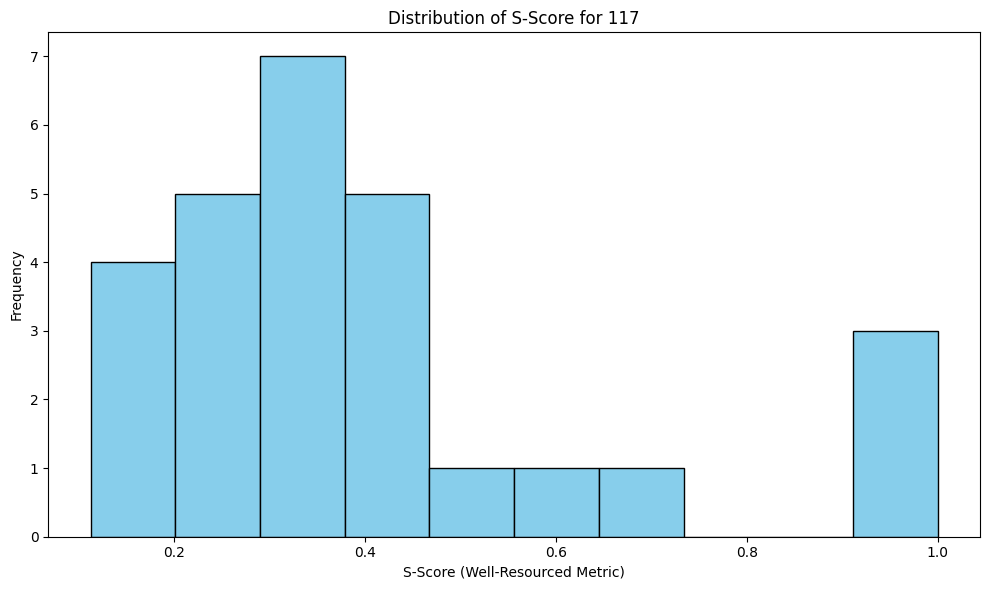

Correlation between Median Income and WR Score: 0.2696


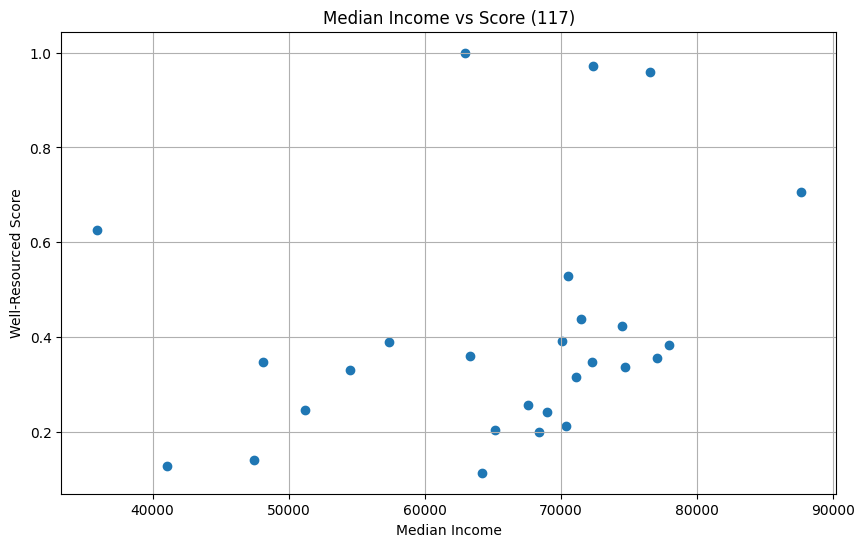

C:\Users\vuduc\AppData\Local\Temp\ipykernel_43556\4225789835.py:73: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



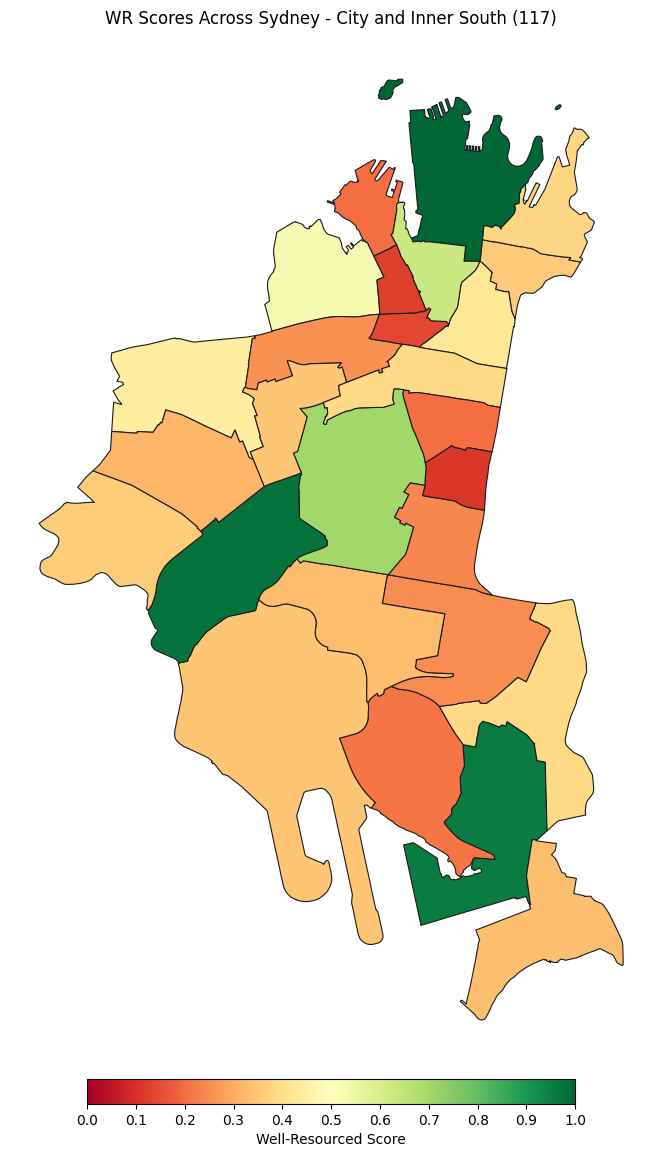

Sydney - Inner South West (119)
The SA2 region with the highest WR Score is 'Chullora' with a score of 0.9997
The SA2 region with the lowest WR Score is 'Wiley Park' with a score of 0.0493
Mean WR Score: 0.4500
Median WR Score: 0.3757
25th percentile WR Score: 0.2314
75th percentile WR Score: 0.5753
Standard Deviation of WR Score: 0.2755


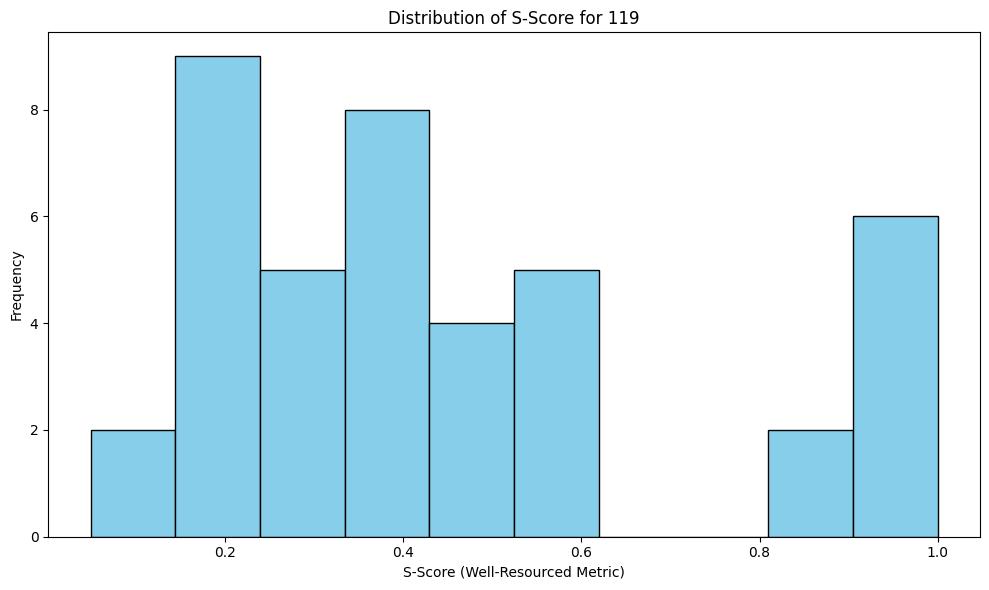

Correlation between Median Income and WR Score: 0.1692


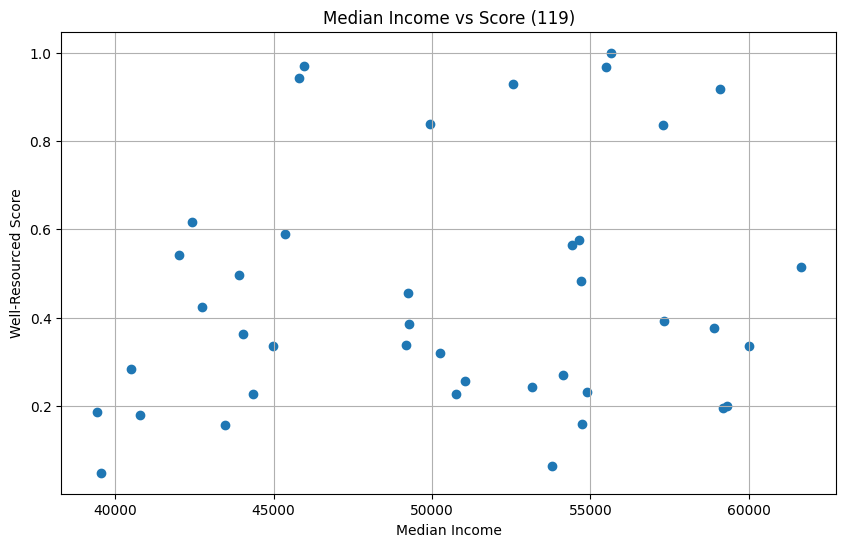

C:\Users\vuduc\AppData\Local\Temp\ipykernel_43556\4225789835.py:73: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



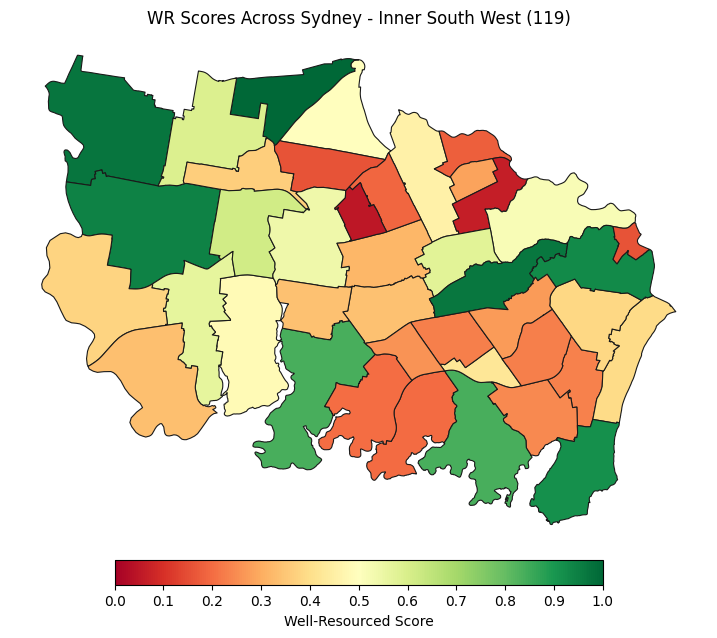

In [ ]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm 
reset()
# test
#calculate_s_score(conn, 117)

# get income data
income = pd.DataFrame(conn.execute(text('SELECT * FROM sa2.income')).fetchall())
income['sa2_code'].astype(int)

# get sa2
sa2table = pd.DataFrame(conn.execute(text('SELECT * FROM sa2.sa2')).fetchall())

# graph 
for sa4 in sa4_codes:
    sa4_code = int(sa4)
    sa4_name = sa2table.loc[sa2table['sa4_code'] == sa4_code, 'sa4_name'].iloc[0]
    print(f"{sa4_name} ({sa4_code})")
    merged_df = pd.merge(calculate_s_score(conn, sa4_code), income, on=['sa2_code', 'sa2_name'], how='inner')
    merged_df = pd.merge(merged_df, sa2table, on=['sa2_code', 'sa2_name'], how='inner')
    #print(merged_df)
    
    max = merged_df['s_score'].idxmax()
    sa2_max = merged_df.loc[max, 'sa2_name']
    max_score = merged_df.loc[max, 's_score']
    print(f"The SA2 region with the highest WR Score is '{sa2_max}' with a score of {max_score:.4f}")

    min = merged_df['s_score'].idxmin()
    sa2_min = merged_df.loc[min, 'sa2_name']
    min_score = merged_df.loc[min, 's_score']
    print(f"The SA2 region with the lowest WR Score is '{sa2_min}' with a score of {min_score:.4f}")

    print(f"Mean WR Score: {merged_df['s_score'].mean():.4f}")
    print(f"Median WR Score: {merged_df['s_score'].median():.4f}")
    print(f"25th percentile WR Score: {merged_df['s_score'].astype(float).quantile(0.25):.4f}")
    print(f"75th percentile WR Score: {merged_df['s_score'].astype(float).quantile(0.75):.4f}")
    print(f"Standard Deviation of WR Score: {merged_df['s_score'].astype(float).std():.4f}")
    plt.figure(figsize=(10, 6))
    plt.hist(merged_df['s_score'], bins=10, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of S-Score for {sa4_code}')
    plt.xlabel('S-Score (Well-Resourced Metric)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    dist = f"{sa4_code}_distribution.jpg"
    plt.savefig(dist)
    plt.show()
    
    print(f"Correlation between Median Income and WR Score: {merged_df['median_income'].corr(merged_df['s_score']):.4f}")
    plt.figure(figsize=(10, 6))
    plt.scatter(merged_df['median_income'], merged_df['s_score'])
    plt.xlabel('Median Income')
    plt.ylabel('Well-Resourced Score')
    plt.title(f'Median Income vs Score ({sa4_code})')
    plt.grid(True)
    plot = f"{sa4_code}_plot.jpg"
    plt.savefig(plot)
    plt.show()


    sa2_geo_df = gpd.read_file('SA2_2021_AUST_SHP_GDA2020\SA2_2021_AUST_GDA2020.shp')
    sa4_geo_df = sa2_geo_df[sa2_geo_df['SA4_CODE21'] == str(sa4_code)]
    
    merged_df['sa2_code'] = merged_df['sa2_code'].astype(str)
    merged_df['s_score'] = merged_df['s_score'].astype(float)

    scores_geo_df = sa4_geo_df.merge(
        merged_df,
        left_on='SA2_CODE21', 
        right_on='sa2_code',
        how='left'
    )

    cmap = cm.get_cmap('RdYlGn') 
    norm = mcolors.Normalize(0, vmax=merged_df['s_score'].max())

    fig, ax = plt.subplots(1, 1, figsize=(10, 15))
    scores_geo_df.plot(
        column='s_score',
        cmap=cmap, 
        norm=norm, 
        linewidth=0.8,
        ax=ax,
        edgecolor='0.1'
    )

    ax.set_title(f'WR Scores Across {sa4_name} ({sa4_code})')
    ax.set_axis_off()

    cbar = fig.colorbar(
        cm.ScalarMappable(norm=norm, cmap=cmap), 
        ax=ax,
        orientation="horizontal",
        shrink=0.7,
        pad=0.01
    )
    cbar.set_label("Well-Resourced Score")

    custom_ticks = np.arange(0.0, 1.1, 0.1)
    cbar.set_ticks(custom_ticks)
    custom_ticklabels = [f"{t:.1f}" for t in custom_ticks]
    cbar.set_ticklabels(custom_ticklabels)

    plt.savefig(f'{sa4_code}_map.jpg', dpi=300, bbox_inches='tight')
    plt.show()
